In [22]:
using BenchmarkTools
paramsfile = "benchmark-2020-05-29_18h49.json"
results = BenchmarkTools.load(paramsfile)[1]

using StructArrays
using DataFrames

data = StructArray([ (pattern=t[1][1], string = t[1][4], code=t[1][2], trial = t[2].time)
              for t in leaves(median(results))
              if t[1][3]=="match" ]) |> DataFrame 
data = unstack(data, [ :pattern, :string], :code, :trial)
groupby(data,:pattern)

,pattern,string,Regcomb,Regex
,String,String,Float64?,Float64?
1,1,1,72.0,194.0
2,1,2,37.0,193.0
,pattern,string,Regcomb,Regex
,String,String,Float64?,Float64?
1,99,1,44.0,178.0


In [178]:
#groupby(data,:pattern)[9]
extrema(filter(x->x!==missing,data.Regcomb))

(33.0, 140512.0)

In [70]:

data[!,:creation] .= data.string.=="1"
data[!,:ratio] .= data.Regcomb./data.Regex


270-element Array{Union{Missing, Float64},1}:
  missing
  missing
  missing
  missing
  missing
  missing
  missing
  missing
  missing
  missing
  missing
  missing
  missing
 ⋮
 0.21893491124260356
 0.2185792349726776
 0.2154696132596685
 0.20833333333333334
 0.20833333333333334
 0.20809248554913296
 0.20118343195266272
 0.19767441860465115
 0.19170984455958548
 0.19047619047619047
 0.1853932584269663
 0.15680473372781065

In [71]:
adata = filter(row -> row.ratio!==missing && row.ratio>0.0 && row.ratio!=NaN,sort(data, :ratio, rev=false))

,pattern,string,Regcomb,Regex,ratio,creation
,String,String,Float64?,Float64?,Float64?,Bool
1,2,4,53.0,338.0,0.156805,0
2,22,1,33.0,178.0,0.185393,1
3,73,3,48.0,252.0,0.190476,0
4,1,2,37.0,193.0,0.19171,0
5,10,2,34.0,172.0,0.197674,0
6,10,1,34.0,169.0,0.201183,1
7,63,1,36.0,173.0,0.208092,1
8,10,3,35.0,168.0,0.208333,0
9,10,4,35.0,168.0,0.208333,0


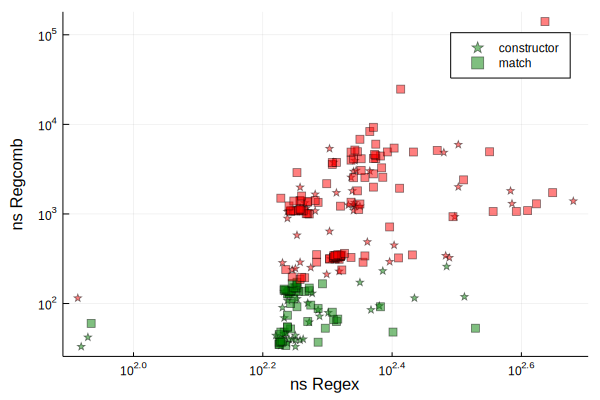

In [200]:
using StatsPlots
plotly()
Plots.PlotlyBackend()
gr()
scatter(adata.Regex, adata.Regcomb, 
    group = adata.type,
    markercolor= [ ratio < 1 ? :green : :red 
        for ratio in adata[!,(:ratio)] ],
    markershape= [ creation ? :star : :rect 
        for creation in adata[!,(:creation)] ],
    alpha=.5)

xaxis!("ns Regex", :log10)#, xlim=(150,600))
yaxis!("ns Regcomb", :log10)

In [201]:
savefig("log_btimes.png")

In [59]:
sum([ c/r <2.0 ? 1 : 0 for (r,c) in zip(adata.Regex, adata.Regcomb)])
sum([ ratio < 1.0 ? 1 : 0 for ratio in adata.ratio])


88

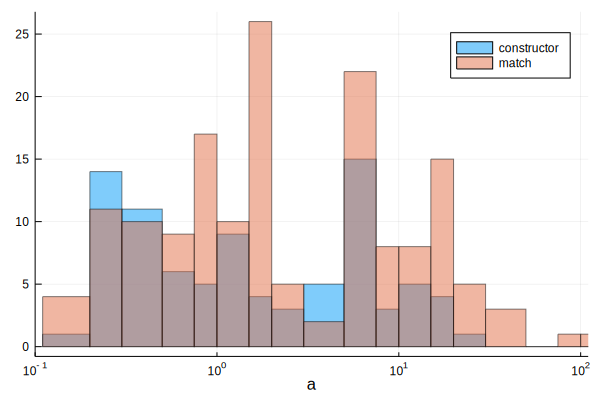

In [193]:
scale = (:xscale=>:log10, 
         :xlim=>(.1,110), 
        :bins=>[.11,.2,.3,.5,.75,1,1.5,2,3,5,7.5,10,15,20,30,50,75,100,1000])
adata[!,:type] = [ c ? "constructor" : "match" for c in adata.creation ]
adata[!,:lratio] = log10.(adata.ratio)
@df adata histogram(:ratio; scale...,group=:type, bar_position=:stack, alpha=.5, xlabel="a")

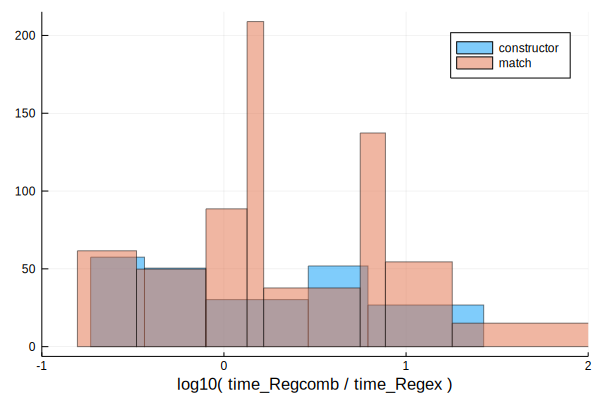

In [198]:
@df adata ea_histogram(:lratio;group=:type,bins=:scott,xlim=(-1,2),bar_position=:stack, alpha=.5, xlabel="log10( time_Regcomb / time_Regex )")

In [199]:
savefig("log_btime_ratio_histogram.svg")

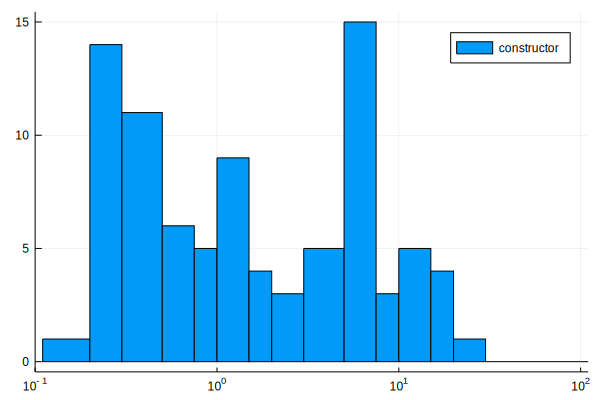

In [152]:
@df filter(x->x.creation,adata) histogram(:ratio; scale..., label="constructor")

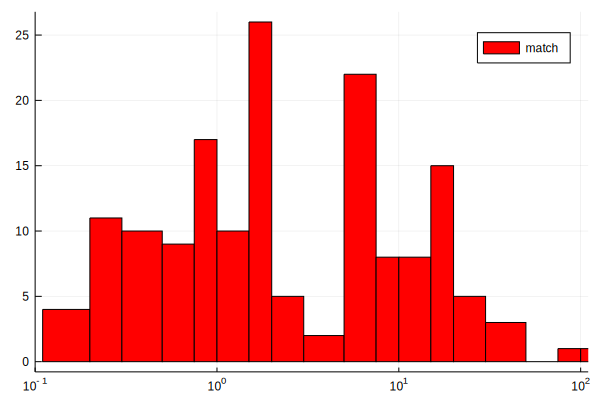

In [154]:
@df filter(x->!x.creation,adata) histogram(:ratio; scale..., label="match", color=:red)
